# Clustering Kmeans PCA Autoencoder

In [1]:
import sys
print(sys.executable)
import platform
print(platform.python_version())

/usr/bin/python3
3.7.11


In [2]:
# Data handling
import pandas as pd 
import numpy as np

# Clustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

In [4]:
def load_preprocess_data():
    """ Load and preprocess data
    """
    # load dataset
    df = pd.read_csv('/content/sample_data/data_credit_card_customer_seg.csv')
    
    # handle missing values by replace it by means
    df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
    df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)
    
    # drop unnecessary column
    df.drop('CUST_ID', axis=1, inplace=True)
    
    return  df

df = load_preprocess_data()
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# **1. Kmeans clustering**
### 1.1 Find the optimal number of clusters

In [5]:
# Data Standardization(Z-score Normalization)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

In [6]:
scaled_df.shape

(8950, 17)

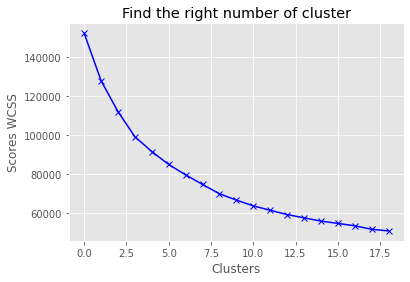

In [7]:
style.use('ggplot')

# Choosing the K value using elbow method 
score_1 = []
range_values = range(1, 20)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scaled_df)
    score_1.append(kmeans.inertia_)

plt.plot(score_1, 'bx-')
plt.title('Find the right number of cluster')
plt.xlabel('Clusters')
plt.ylabel('Scores WCSS')
plt.show()

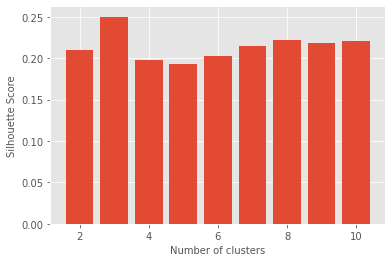

In [8]:
# silhouette score
silhouette_scores = []

for n_cluster in range(2, 11):
    silhouette_scores.append(silhouette_score(scaled_df, KMeans(n_clusters = n_cluster).fit_predict(scaled_df))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7, 8, 9, 10] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 3

### 1.2 Apply K-means with all features

In [21]:
# k-means++ ensures not falling into random initialization trap
kmeans = KMeans(n_clusters =3 , init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
labels = kmeans.fit_predict(scaled_df)

### 1.3 Cluster feature visualization

In [22]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

1    6103
2    1595
0    1252
Name: cluster, dtype: int64

In [23]:
clusters.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,2197.296209,0.981438,4233.043267,2697.663874,1535.858626,455.603491,0.948701,0.669259,0.739333,0.062830,1.523163,56.112620,7687.659744,4118.077849,1214.668536,0.301078,11.916933
1,800.461057,0.834815,502.180541,250.346708,252.155471,330.479456,0.463577,0.130595,0.344889,0.068357,1.212355,8.588727,3266.732432,907.867214,548.679183,0.154824,11.478945
2,3991.110361,0.957954,385.018966,248.886107,136.210395,3870.573521,0.233011,0.111012,0.144960,0.447457,12.395611,5.631975,6685.582787,3018.865455,1796.422881,0.033796,11.350470


Text(0.5, 0, 'SEGMENTS')

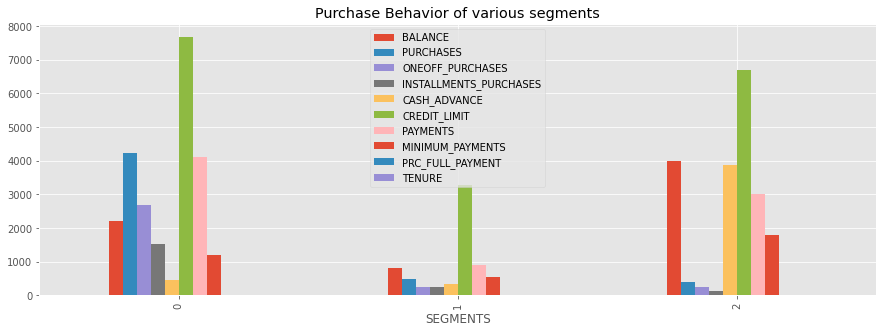

In [24]:
# Cluster feature visualization
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

### 1.4 Principle component analysis

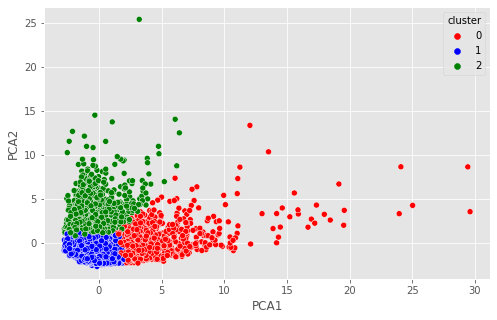

In [25]:
# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['PCA1', 'PCA2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="PCA1", y="PCA2", hue="cluster",palette=['red','blue','green'])
plt.show()

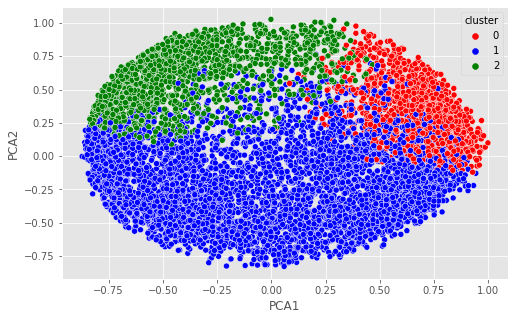

In [26]:
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(normalized_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['PCA1', 'PCA2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="PCA1", y="PCA2", hue="cluster",palette=['red','blue','green'])
plt.show()

# **2. Autoencoder**

1. Autoencoder a type of nn to perform data encoding
2. Unsupervised learning with encoding and decoding
3. fit the model with the same input and output
4. Adding a bottle neck in the network
5. Work well for correlated data

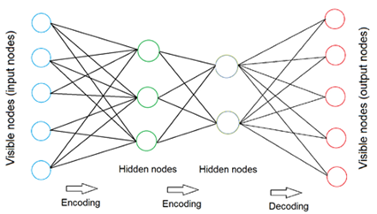

Here we will create a stacked auto encode. In a stacked autoencoder model, encoder and decoder have multiple hidden layers for encoding and decoding

1. Input tensor is batches of 17-dimension vectors because our data have 17 features.
2. The network bottleneck’s output dimension is 10, as we aim to compress 17 features to 10 features.
3. The final output of the network, decoded has a dimension of 17, the same as the input dimension.
4. The Autoencoder model takes input_df as input and decoded as output.
5. The encoder model takes input_df as input and encoded as output.
6. We use glorot_uniform to initialize the layer weights by drawing samples from a uniform distribution.

In [27]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential

### 2.1 create a model

In [32]:
# create a model
input_df = Input( shape = (17, ))

x = Dense(7, activation = 'relu')(input_df)

x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)

x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)

x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(x)

encoded = Dense(10, activation = 'relu', kernel_initializer='glorot_uniform')(x)

x = Dense(2000, activation = 'relu', kernel_initializer='glorot_uniform')(encoded)

x = Dense(500, activation = 'relu', kernel_initializer='glorot_uniform')(x)

decoded = Dense(17, kernel_initializer='glorot_uniform')(x)

autoencoder = Model(input_df, decoded)

encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

### 2.2 Fit autoencoder

In [36]:
autoencoder.fit(scaled_df,scaled_df, batch_size= 120, epochs = 25, verbose = 1)

Epoch 1/25
75/75 [==============================] - 4s 52ms/step - loss: 0.0358
Epoch 2/25
75/75 [==============================] - 4s 55ms/step - loss: 0.0305
Epoch 3/25
75/75 [==============================] - 4s 57ms/step - loss: 0.0379
Epoch 4/25
75/75 [==============================] - 4s 58ms/step - loss: 0.0266
Epoch 5/25
75/75 [==============================] - 4s 58ms/step - loss: 0.0269
Epoch 6/25
75/75 [==============================] - 4s 58ms/step - loss: 0.0299
Epoch 7/25
75/75 [==============================] - 4s 56ms/step - loss: 0.0314
Epoch 8/25
75/75 [==============================] - 4s 54ms/step - loss: 0.0319
Epoch 9/25
75/75 [==============================] - 4s 54ms/step - loss: 0.0274
Epoch 10/25
75/75 [==============================] - 4s 58ms/step - loss: 0.0251
Epoch 11/25
75/75 [==============================] - 4s 58ms/step - loss: 0.0227
Epoch 12/25
75/75 [==============================] - 4s 56ms/step - loss: 0.0238
Epoch 13/25
75/75 [==================

In [38]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 126       
_________________________________________________________________
dense_25 (Dense)             (None, 500)               4000      
_________________________________________________________________
dense_26 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_27 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_28 (Dense)             (None, 10)                20010     
_________________________________________________________________
dense_29 (Dense)             (None, 2000)              2200

### 2.3 Feature compression
 we can use the encoder part to extract the feature representation.

In [39]:
pred = encoder.predict(scaled_df)
pred.shape

(8950, 10)

# **3. Kmeans with encoded data**

### 3.1 Find the optimal cluster number & compare score1 and score2

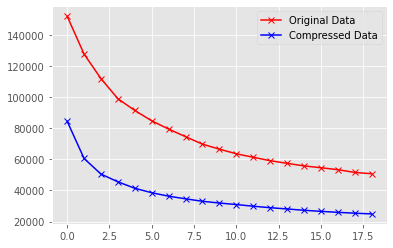

In [40]:
score_2 = []
range_values = range(1, 20)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(pred)
    score_2.append(kmeans.inertia_)
  
plt.plot(score_1, 'bx-', color = 'r', label = 'Original Data')
plt.plot(score_2, 'bx-', color = 'b', label = 'Compressed Data')
plt.legend()

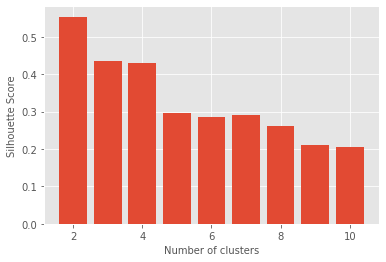

In [41]:
# silhouette score
silhouette_scores = []

for n_cluster in range(2, 11):
    silhouette_scores.append(silhouette_score(pred, KMeans(n_clusters = n_cluster).fit_predict(pred))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7, 8, 9, 10] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 2

### **K=2**

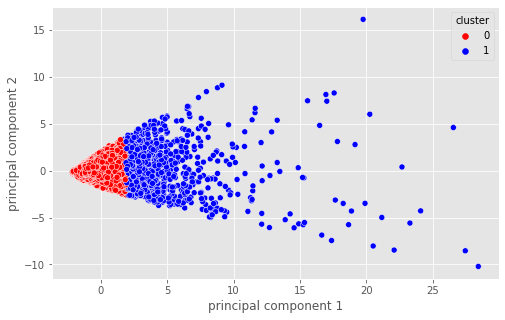

In [42]:
# Apply Kmeans algorithm
kmean= KMeans(n_clusters=2,init='k-means++')
kmean.fit(pred)
labels=kmean.labels_


# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pred)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="principal component 1", y="principal component 2", hue="cluster",palette=['red','blue'])
plt.show()

0    7833
1    1117
Name: cluster, dtype: int64


Text(0.5, 0, 'SEGMENTS')

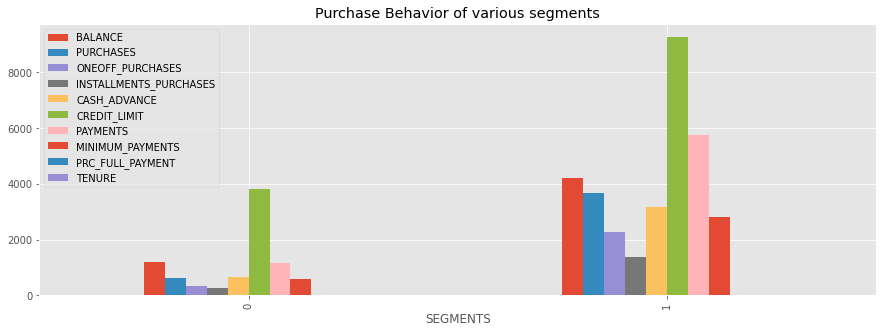

In [43]:
# Cluster feature visualization
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
print(clusters['cluster'].value_counts())
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

## **K=3**

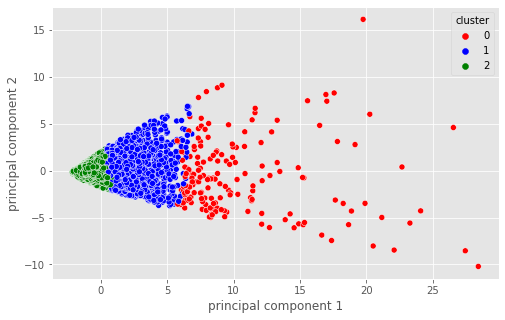

In [47]:
# Kmeans algorithm
kmean= KMeans(n_clusters=3,init='k-means++')
kmean.fit(pred)
labels=kmean.labels_


# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pred)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="principal component 1", y="principal component 2", hue="cluster",palette=['red','blue','green'])
plt.show()

2    6799
1    1972
0     179
Name: cluster, dtype: int64


Text(0.5, 0, 'SEGMENTS')

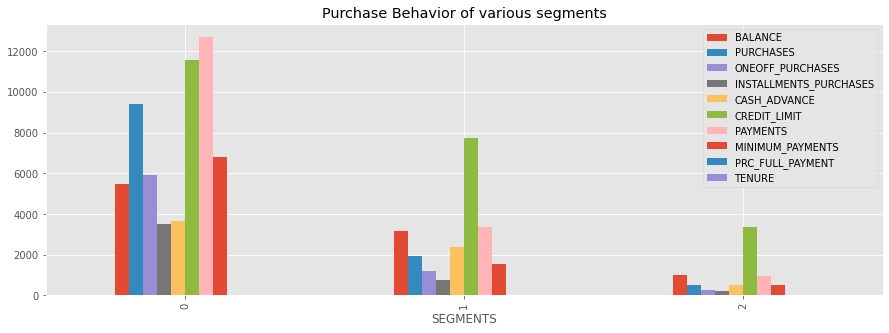

In [48]:
# Cluster feature visualization
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
print(clusters['cluster'].value_counts())
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

## **K=4**

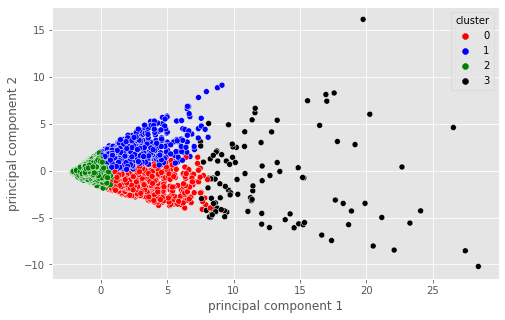

In [51]:
# Kmeans algorithm
kmean= KMeans(n_clusters=4,init='k-means++')
kmean.fit(pred)
labels=kmean.labels_


# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pred)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot( data=finalDf,x="principal component 1", y="principal component 2", hue="cluster",palette=['red','blue','green','black'])
plt.show()

2    6782
1    1057
0    1006
3     105
Name: cluster, dtype: int64


Text(0.5, 0, 'SEGMENTS')

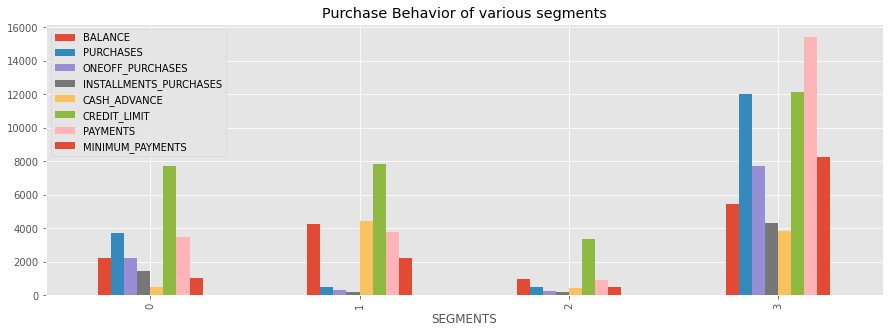

In [62]:
# Cluster feature visualization
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
print(clusters['cluster'].value_counts())
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

# **Classification algorithm to predict**

Top 7 columns
1. BALANCE 
2. PURCHASES 
3. ONEOFF_PURCHASES
4. INSTALLMENTS_PURCHASES
5. CASH_ADVANCE 
6. CREDIT_LIMIT 
7. PAYMENTS

In [63]:
clusters.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,2
1,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1


In [65]:
clusters.shape

(8950, 18)

In [125]:
clusters['cluster'].value_counts()

2    6782
1    1057
0    1006
3     105
Name: cluster, dtype: int64

In [66]:
# drop unnecessary columns
clusters = clusters.drop(['BALANCE_FREQUENCY','PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
        'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE'],axis=1)

In [67]:
clusters.shape

(8950, 8)

In [88]:
# Libraries
from sklearn.model_selection import train_test_split #for splitting the data in train and test
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler #for various scaling methods
from sklearn.linear_model import LogisticRegression #for LogisticRegression
from sklearn.naive_bayes import GaussianNB #for NaiveBayes
from sklearn.neighbors import KNeighborsClassifier #for KNN
from sklearn.svm import SVC #for Support vector classifier

from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....
from os import system #using user environment
from sklearn.ensemble import RandomForestClassifier #for random forest
from sklearn.preprocessing import LabelEncoder #for lebel encoder

from sklearn.metrics import accuracy_score,confusion_matrix,recall_score #for accuracy matrices
from sklearn.metrics import precision_score,classification_report,roc_auc_score,precision_score #for accuracy matrices


In [69]:
# Split independent and dependent
X = clusters.drop('cluster',axis=1) #independent dimensions  
y = clusters['cluster'] #selecting target column
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1) #train test split in 70:30 ratio

In [100]:
# Scaling of columns
scaler = StandardScaler() #using standard scaler method
X_train_scaled = scaler.fit_transform(X_train) #Scaling of Train dataset
X_test_scaled = scaler.fit_transform(X_test) #Scaling of Test dataset

### **1. Logistic regression**

In [76]:
logic_r = LogisticRegression() #Instantiate the LogisticRegression object
logic_r.fit(X_train_scaled,y_train) #Call the fit method of logistic regression to train the model or to learn the parameters of model
y_pred = logic_r.predict(X_test_scaled) #Predict  

print('\033[1m''->'*63)
print('\033[1m''Confusion Matrix\n',confusion_matrix(y_test,y_pred)) #for confusion matrix
print('-'*40)
LR_accuracy = accuracy_score(y_test,y_pred)
print('Accuracy of Logistic Regression :{:.2f}'.format(LR_accuracy)) #for accuracy score
print('-'*40)
print('\n Classification Report\n',classification_report(y_test,y_pred)) #for classification report
print('->'*63)

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->
Confusion Matrix
 [[ 219    7   82    0]
 [  11  215   95    0]
 [  19   40 1958    0]
 [   8    2    5   24]]
----------------------------------------
Accuracy of Logistic Regression :0.90
----------------------------------------

 Classification Report
               precision    recall  f1-score   support

           0       0.85      0.71      0.78       308
           1       0.81      0.67      0.74       321
           2       0.91      0.97      0.94      2017
           3       1.00      0.62      0.76        39

    accuracy                           0.90      2685
   macro avg       0.90      0.74      0.80      2685
weighted avg       0.90      0.90      0.90      2685

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->


# **2. KNN**

In [83]:
# k=3
knn = KNeighborsClassifier(n_neighbors = 3)  #Instantiate KNN with k=3
knn.fit(X_train_scaled,y_train) #Call the fit method of KNN to train the model or to learn the parameters of model
y_predict = knn.predict(X_test_scaled) #Predict 

print('\033[1m''->'*63)
print('\033[1m''Confusion Matrix\n',confusion_matrix(y_test,y_predict)) #for confusion matrix
print('-'*30)
KNN_accuracy = accuracy_score(y_test,y_predict)
print('Accuracy of KNN :{:.2f}'.format(KNN_accuracy)) #for accuracy score
print('-'*30)
print('\n Classification Report\n',classification_report(y_test,y_predict)) #for classification report
print('->'*63)

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->
Confusion Matrix
 [[ 204    8   96    0]
 [  19  213   89    0]
 [  25   35 1957    0]
 [  14    4    2   19]]
------------------------------
Accuracy of KNN :0.89
------------------------------

 Classification Report
               precision    recall  f1-score   support

           0       0.78      0.66      0.72       308
           1       0.82      0.66      0.73       321
           2       0.91      0.97      0.94      2017
           3       1.00      0.49      0.66        39

    accuracy                           0.89      2685
   macro avg       0.88      0.70      0.76      2685
weighted avg       0.89      0.89      0.89      2685

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->


# **3. Support Vector Machine**

In [86]:
svc = SVC()  #Instantiate SVC
svc.fit(X_train_scaled,y_train) #Call the fit method of SVC to train the model or to learn the parameters of model
predicted_svc = svc.predict(X_test_scaled) #Predict 

print('\033[1m''->'*63)
print('\033[1m''Confusion Matrix\n',confusion_matrix(y_test,predicted_svc)) #for confusion matrix
print('-'*30)
SVC_accuracy = accuracy_score(y_test,predicted_svc) #for accuracy score
print('Accuracy of SVC :',SVC_accuracy*100)
print('-'*30)
print('\n Classification Report\n',classification_report(y_test,predicted_svc)) #for classification report
print('->'*63)

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->
Confusion Matrix
 [[ 208    7   93    0]
 [  16  207   97    1]
 [  10   22 1985    0]
 [   8    2    4   25]]
------------------------------
Accuracy of SVC : 90.31657355679702
------------------------------

 Classification Report
               precision    recall  f1-score   support

           0       0.86      0.68      0.76       308
           1       0.87      0.64      0.74       321
           2       0.91      0.98      0.95      2017
           3       0.96      0.64      0.77        39

    accuracy                           0.90      2685
   macro avg       0.90      0.74      0.80      2685
weighted avg       0.90      0.90      0.90      2685

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->


# **4. Decision Tree**

In [89]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1) #Instantiate Decision Tree
dTree.fit(X_train, y_train) #Call the fit method of DT to train the model or to learn the parameters of model
predicted_DT = dTree.predict(X_test) #Predict 

print('\033[1m''->'*63)
print('\033[1m''Confusion Matrix\n',confusion_matrix(y_test,predicted_DT)) #for confusion matrix
print('-'*30)
DT_accuracy = accuracy_score(y_test,predicted_DT)
print('Accuracy of Decision Tree :{:.2f}'.format(DT_accuracy)) #for accuracy score
print('-'*30)
print('\n Classification Report\n',classification_report(y_test,predicted_DT)) #for classification report
print('->'*63)

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->
Confusion Matrix
 [[ 222    9   75    2]
 [  19  212   88    2]
 [  60   75 1882    0]
 [   6    4    5   24]]
------------------------------
Accuracy of Decision Tree :0.87
------------------------------

 Classification Report
               precision    recall  f1-score   support

           0       0.72      0.72      0.72       308
           1       0.71      0.66      0.68       321
           2       0.92      0.93      0.93      2017
           3       0.86      0.62      0.72        39

    accuracy                           0.87      2685
   macro avg       0.80      0.73      0.76      2685
weighted avg       0.87      0.87      0.87      2685

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->


## **4.1 Pruning of Decision Tree**

In [96]:
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state=0) #Instantiate Decision Tree with max_depth
dTreeR.fit(X_train, y_train) #Call the fit method of DT to train the model or to learn the parameters of model
predicted_DTR = dTreeR.predict(X_test) #Predict

print('\033[1m''->'*63)
print('\033[1m''Confusion Matrix\n',confusion_matrix(y_test,predicted_DTR)) #for confusion matrix
print('-'*30)
DTR_accuracy = accuracy_score(y_test,predicted_DTR)
print('Accuracy of Decision Tree with Regularization:{:.2f}'.format(DTR_accuracy)) #for accuracy score
print('-'*30)
print('\n Classification Report\n',classification_report(y_test,predicted_DTR)) #for classification report
print('->'*63)

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->
Confusion Matrix
 [[ 205    2   97    4]
 [  16  186  119    0]
 [  27   26 1964    0]
 [   9    2    5   23]]
------------------------------
Accuracy of Decision Tree with Regularization:0.89
------------------------------

 Classification Report
               precision    recall  f1-score   support

           0       0.80      0.67      0.73       308
           1       0.86      0.58      0.69       321
           2       0.90      0.97      0.93      2017
           3       0.85      0.59      0.70        39

    accuracy                           0.89      2685
   macro avg       0.85      0.70      0.76      2685
weighted avg       0.88      0.89      0.88      2685

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->


# **5. Random forest**

In [102]:
#n=500
randf = RandomForestClassifier(n_estimators = 500, random_state=1, max_features=5) #Instantiate Random Forest Classifier
randf = randf.fit(X_train, y_train)  #Call the fit method of Random Forest Classifier to train the model or to learn the parameters of model
predicted_RANN = randf.predict(X_test) #Predict

print('\033[1m''->'*63)
print('\033[1m''Confusion Matrix\n',confusion_matrix(y_test,predicted_RANN)) #for confusion matrix
print('-'*30)
RANN_accuracy = accuracy_score(y_test,predicted_RANN)
print('Accuracy of Random Forest :{:.2f}'.format(RANN_accuracy)) #for accuracy score
print('-'*30)
print('\n Classification Report\n',classification_report(y_test,predicted_RANN)) #for classification report
print('->'*63)

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->
Confusion Matrix
 [[ 236    5   66    1]
 [  14  223   84    0]
 [  29   43 1945    0]
 [   8    3    4   24]]
------------------------------
Accuracy of Random Forest :0.90
------------------------------

 Classification Report
               precision    recall  f1-score   support

           0       0.82      0.77      0.79       308
           1       0.81      0.69      0.75       321
           2       0.93      0.96      0.95      2017
           3       0.96      0.62      0.75        39

    accuracy                           0.90      2685
   macro avg       0.88      0.76      0.81      2685
weighted avg       0.90      0.90      0.90      2685

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->


# **6. Naive Bayes**

In [103]:
NB = GaussianNB()   #Instantiate the Gaussian Naive bayes 
NB.fit(X_train_scaled,y_train) #Call the fit method of NB to train the model or to learn the parameters of model
y_predi = NB.predict(X_test_scaled) #Predict 

print('\033[1m''->'*63)
print('\033[1m''Confusion Matrix\n',confusion_matrix(y_test,y_predi)) #for confusion matrix
print('-'*30)
NB_accuracy = accuracy_score(y_test,y_predi)
print('Accuracy of Naive Bayes :{:.2f}'.format(NB_accuracy)) #for accuracy score
print('-'*30)
print('\n Classification Report\n',classification_report(y_test,y_predi)) #for classification report
print('->'*63)

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->
Confusion Matrix
 [[ 239   16   49    4]
 [  16  239   62    4]
 [  46   95 1876    0]
 [   4    4    2   29]]
------------------------------
Accuracy of Naive Bayes :0.89
------------------------------

 Classification Report
               precision    recall  f1-score   support

           0       0.78      0.78      0.78       308
           1       0.68      0.74      0.71       321
           2       0.94      0.93      0.94      2017
           3       0.78      0.74      0.76        39

    accuracy                           0.89      2685
   macro avg       0.80      0.80      0.80      2685
weighted avg       0.89      0.89      0.89      2685

->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->


# Models with accuracy scores

In [105]:
Scores = [('Naive bayes', NB_accuracy),
      ('KNN', KNN_accuracy),
      ('Logistic Regression', LR_accuracy),
      ('SVC', SVC_accuracy ),
      ('Decision Tree',DT_accuracy),
      ('Decision Tree with Regularization',DTR_accuracy),
      ('Random Forest N=100',RANN_accuracy)] #List of accuracy scores of all models

Scores = pd.DataFrame(Scores,columns=['Model','Accuracy score']) #Conversion of list to dataframe

Scores.sort_values(by='Accuracy score',ascending=False) #Sort values in descending manner

,Model,Accuracy score
6,Random Forest N=100,0.904283
3,SVC,0.903166
2,Logistic Regression,0.899814
1,KNN,0.891248
0,Naive bayes,0.887523
5,Decision Tree with Regularization,0.885661
4,Decision Tree,0.871508


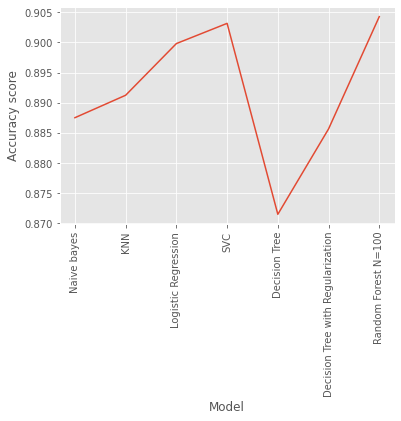

In [106]:
sns.lineplot(x=Scores['Model'],y=Scores['Accuracy score'],data=Scores,markers=True, dashes=False) #Countplot of Scores
plt.xticks(rotation=90)
plt.show()

## Create a model using random forest

In [108]:
#n=500
randf = RandomForestClassifier(n_estimators = 500, random_state=1, max_features=5) #Instantiate Random Forest Classifier
randf = randf.fit(X_train, y_train)  #Call the fit method of Random Forest Classifier to train the model or to learn the parameters of model
predicted_RANN = randf.predict(X_test) #Predict

# Now let's compare some of our predicted values with the actual values 
df=pd.DataFrame({'Actual':y_test, 'Predicted':predicted_RANN})  
df  

,Actual,Predicted
4248,2,2
7432,1,2
4668,3,0
5339,2,2
2031,2,2
...,...,...
2958,2,2
2899,2,2
5862,2,2
4247,2,2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


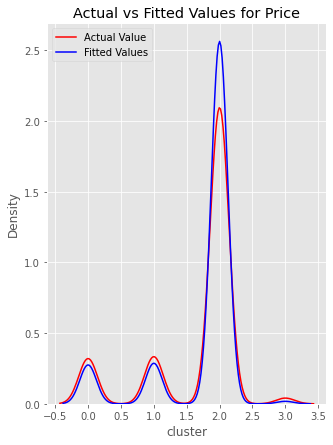

In [110]:
import seaborn as sns
plt.figure(figsize=(5, 7))

ax = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)

plt.title('Actual vs Fitted Values for Price')
plt.legend()
plt.show()
plt.close()

## Predict 

In [135]:
own_pred = randf.predict(np.array([[348.321822,0.0,0.0,0.0,178.138151,500,142.741177]]))
print("Cluster = {}".format(own_pred[0]))
print('-'*15)
own_pred = randf.predict(np.array([[1061.439175,0.00,0.0,0.00,137.757459,1200.0,446.265741]]))
print("Cluster = {}".format(own_pred[0]))
print('-'*15)
own_pred = randf.predict(np.array([[1418.254924,362.13,0.0,362.13,0.000000,1200.0,496.114334]]))
print("Cluster = {}".format(own_pred[0]))

Cluster = 2
---------------
Cluster = 2
---------------
Cluster = 1


In [126]:
X_train.head(3)

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS
7562,348.321822,0.00,0.0,0.00,178.138151,500.0,142.741177
2942,1061.439175,0.00,0.0,0.00,137.757459,1200.0,446.265741
666,1418.254924,362.13,0.0,362.13,0.000000,1200.0,496.114334


In [127]:
y_train.head(3)

7562    2
2942    2
666     1
Name: cluster, dtype: int32

## Save model

In [137]:
# Here, we will save the 'lr' model to disk as 'model.py'

import pickle

pickle.dump(randf,open('model.pkl','wb'))
# Dump this model by the name "model.py" in the systems HDD and while doing this
# write this file using "write bytes" mode.

In [138]:
# Lets now try to load the same model by reading it from the system
# and using it for prediction

model = pickle.load(open("model.pkl","rb"))

In [139]:
model.predict([[348.321822,0.0,0.0,0.0,178.138151,500,142.741177]])

array([2], dtype=int32)